In [1]:
import os
import numpy as np
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi
from dipy.data.fetcher import fetch_syn_data
from dipy.io.image import load_nifti
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)
from dipy.align import affine_registration, register_dwi_to_template

from misc_utils import get_matched_ids
import nibabel as nib

/Users/asagilmore/miniconda3/envs/t1wmra/lib/python3.11/site-packages/dipy/viz/__init__.py:22: UserWarning: You do not have FURY installed. Therefore, 3D visualization functions will not work for you. Please install or upgrade FURY using pip install -U furyFor detailed installation instructions visit: https://fury.gl/
  warnings.warn(
/Users/asagilmore/miniconda3/envs/t1wmra/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def align_images(static_path, moving_path):
    static_data, static_affine, static_img = load_nifti(static_path, return_img=True)
    static_grid2world = static_affine
    static = static_data
    static_grid2world = static_affine

    moving_data, moving_affine, moving_img = load_nifti(moving_path, return_img=True)
    moving = moving_data
    moving_grid2world = moving_affine

    identity = np.eye(4)
    affine_map = AffineMap(identity,
                           static.shape, static_grid2world,
                           moving.shape, moving_grid2world)
    resampled = affine_map.transform(moving)

    return static_affine, resampled

def get_scan_from_id(directory, unique_string):
    filenames = os.listdir(directory)

    matching_files = [filename for filename in filenames if unique_string in filename]

    if len(matching_files) > 1:
        raise ValueError(f"Error: More than one file contains the string '{unique_string}'")
    elif len(matching_files) == 0:
        raise ValueError(f"No files found containing the string '{unique_string}'")
    else:
        return os.path.join(directory, matching_files[0])

def get_static(static_path):
    static_data, static_affine, static_img = load_nifti(static_path, return_img=True)
    static_grid2world = static_affine
    static = static_data

    return static

def crop(scan, crop_scan):
    mask = crop_scan > 0
    scan_masked = np.where(mask, static, 0)
    return scan_masked

In [3]:
root = "/Users/asagilmore/src/t1-to-mra/data/raw-mini"
t1_path = os.path.join(root, "T1W")
t2_path = os.path.join(root, "T2W")
mra_path = os.path.join(root, "MRA")
paths = [t1_path, t2_path, mra_path]

uids = get_matched_ids(paths)

In [5]:
# register all other scans to the T1

t1_out_path = "/Users/asagilmore/src/t1-to-mra/data/registered-mini/T1W"
t2_out_path = "/Users/asagilmore/src/t1-to-mra/data/registered-mini/T2W"
mra_out_path = "/Users/asagilmore/src/t1-to-mra/data/registered-mini/MRA"

for uid in uids:
    t1_file = get_scan_from_id(t1_path, uid)
    t2_file = get_scan_from_id(t2_path, uid)
    mra_file = get_scan_from_id(mra_path, uid)

    t2_affine, t2_registered = align_images(t1_file, t2_file)
    mra_affine, mra_registered = align_images(t1_file, mra_file)
    t1_data, t1_affine, t1_img = load_nifti(t1_file, return_img=True)

    mra_mask = mra_registered > 0
    t1_cropped = np.where(mra_mask, t1_data, 0)
    t2_cropped = np.where(mra_mask, t2_registered, 0)

    t1_nifti = nib.Nifti1Image(t1_cropped, t1_affine)
    t2_nifti = nib.Nifti1Image(t2_cropped, t2_affine)

    mra_nifti = nib.Nifti1Image(mra_registered, mra_affine)
    nib.save(mra_nifti, os.path.join(mra_out_path, f"{uid}_MRA.nii.gz"))


    nib.save(t2_nifti, os.path.join(t2_out_path, f"{uid}_T2W.nii.gz"))
    nib.save(t1_nifti, os.path.join(t1_out_path, f"{uid}_T1W.nii.gz"))

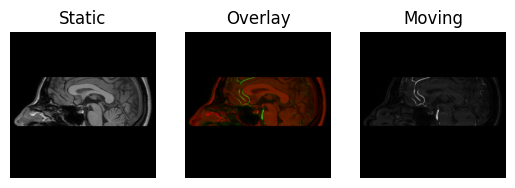

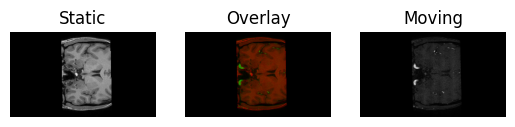

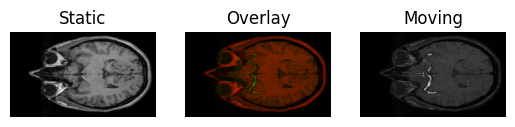

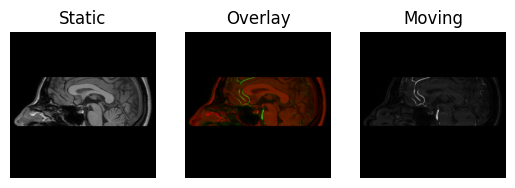

In [11]:
# Affine registration [Mattes03]
def align_images_temp(static_path, moving_path):
    static_data, static_affine, static_img = load_nifti(static_path, return_img=True)
    static_grid2world = static_affine
    static = static_data
    static_grid2world = static_affine

    moving_data, moving_affine, moving_img = load_nifti(moving_path, return_img=True)
    moving = moving_data
    moving_grid2world = moving_affine

    identity = np.eye(4)
    affine_map = AffineMap(identity,
                           static.shape, static_grid2world,
                           moving.shape, moving_grid2world)
    resampled = affine_map.transform(moving)

    return resampled

t1_path = "/Users/asagilmore/src/t1-to-mra/data/raw-mini/T1W/IXI002-Guys-0828-T1.nii.gz"
mra_path = "/Users/asagilmore/src/t1-to-mra/data/raw-mini/MRA/IXI002-Guys-0828-MRA.nii.gz"

static = get_static(t1_path)
resampled = align_images_temp(t1_path, mra_path)

mask = resampled > 0
static_masked = np.where(mask, static, 0)

regtools.overlay_slices(static_masked, resampled, None, 0,
                        "Static", "Moving", "resampled_0.png")
regtools.overlay_slices(static_masked, resampled, None, 1,
                        "Static", "Moving", "resampled_1.png")
regtools.overlay_slices(static_masked, resampled, None, 2,
                        "Static", "Moving", "resampled_2.png")

